# Inventory management example

In [1]:
import matplotlib.pyplot as plt
from mlopt.sampling import uniform_sphere_sample
import mlopt
import pandas as pd
import cvxpy as cp
import numpy as np
import os

np.random.seed(0)

/Users/sidereus/Dropbox/research/code/projects/learning_opt/mlopt/mlopt/utils.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Generate Optimizer

In [2]:
np.random.seed(1)
T = 30
M = 3.
h = 1.
c = 2.
p = 3.

# Define problem
x = cp.Variable(T+1)
u = cp.Variable(T)

# Define parameters
d = cp.Parameter(T, nonneg=True, name="d")
x_init = cp.Parameter(1, name="x_init")

# Constaints
constraints = [x[0] == x_init]
for t in range(T):
    constraints += [x[t+1] == x[t] + u[t] - d[t]]
constraints += [u >= 0, u <= M]

# Objective
cost = cp.sum(cp.maximum(h * x, -p * x)) + c * cp.sum(u)

# Define optimizer
m = mlopt.Optimizer(cp.Minimize(cost), constraints)

# Sample points

In [3]:
# Average request
theta_bar = np.concatenate(( 2 * np.ones(T),  # d
                            [10]              # x_init
                           ))
radius = 1


def sample_inventory(theta_bar, radius, n=100):

    # Sample points from multivariate ball
    X_d = uniform_sphere_sample(theta_bar[:-1], radius, n=n)
    X_x_init = uniform_sphere_sample([theta_bar[-1]], 3 * radius,
                                     n=n)

    df = pd.DataFrame({'d': X_d.tolist(),
                       'x_init': X_x_init.tolist()})

    return df

# Train

In [4]:
# Training and testing data
n_train = 1000
n_test = 100
theta_train = sample_inventory(theta_bar, radius, n=n_train)
theta_test = sample_inventory(theta_bar, radius, n=n_test)

# Train solver
m.train(theta_train,
        learner=mlopt.OPTIMAL_TREE,
        n_best=3,
        max_depth=[1, 5, 10],
        minbucket=[1, 5, 10],
        parallel_trees=True,
        save_svg=True)
#  m.train(theta_train, learner=mlopt.PYTORCH)

Use new data
Compute tight constraints for training set (n_jobs = 4)



Encoding strategies
Getting unique set of strategies
Found 4 unique strategies
No labels appearing only once
Caching KKT solver factors for each strategy (it works only for QP-representable problems with parameters only in constraints RHS)



Training trees on 4 processors
Tree training time 57.32


In [5]:
m._learner._lnr

Fitted OptimalTreeClassifier:
  1) Split: x31 < 9.886
    2) Split: x3 < 1.951
      3) Split: x31 < 7.803
        4) Predict: 3 (89.83%), [0,6,0,53], 59 points, error 6
        5) Predict: 1 (90.40%), [7,113,0,5], 125 points, error 12
      6) Split: x31 < 8.158
        7) Predict: 3 (96.69%), [0,4,0,117], 121 points, error 4
        8) Predict: 1 (96.82%), [2,152,0,3], 157 points, error 5
    9) Split: x31 < 11.82
      10) Split: x31 < 10.4
        11) Split: x1 < 2.121
          12) Split: x30 < 1.858
            13) Predict: 1 (64.71%), [6,11,0,0], 17 points, error 6
            14) Predict: 0 (90.20%), [46,5,0,0], 51 points, error 5
          15) Predict: 1 (80.00%), [4,16,0,0], 20 points, error 4
        16) Predict: 0 (91.45%), [214,2,18,0], 234 points, error 20
      17) Split: x31 < 12.25
        18) Split: x2 < 2.119
          19) Split: x3 < 2.072
            20) Predict: 2 (77.78%), [12,0,42,0], 54 points, error 12
            21) Predict: 0 (76.19%), [16,0,5,0], 21 points, error 5
          22) Predict: 0 (83.33%), [15,0,3,0], 18 points, error 3
        23) Predict: 2 (92.68%), [9,0,114,0], 123 points, error 9

In [6]:
output = "oct_inv"

# Save solver
m.save(output, delete_existing=True)

# Benchmark
results_general, results_detail = m.performance(theta_test)
results_general.to_csv(output + "_general.csv", header=True)
results_detail.to_csv(output + "_detail.csv", header=True)

results_general

Performance evaluation
Compute tight constraints for test set (n_jobs = 1)


Academic license - for non-commercial use only




Predict tight constraints for test set


problem                     problem
learner                 optimaltree
n_best                            3
n_var                            61
n_constr                         91
n_test                          100
n_train                        1000
n_theta                          31
good_turing                       0
good_turing_smooth             0.01
n_correct                       100
n_strategies                      4
accuracy                        100
n_infeas                          0
avg_infeas              4.62234e-16
std_infeas               8.6033e-16
avg_subopt             -2.92803e-17
std_subopt              1.02271e-16
max_infeas              5.96277e-15
max_subopt              2.17983e-16
mean_solve_time_pred    0.000387163
std_solve_time_pred     0.000368599
mean_pred_time_pred       0.0311166
std_pred_time_pred      1.04083e-17
mean_time_pred            0.0315038
std_time_pred           0.000368599
mean_time_full          0.000853114
std_time_full           0.00

# Plot behavior


Predict optimal solution


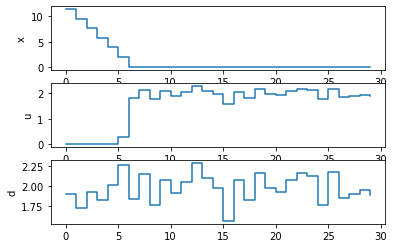

In [7]:
# Solve with single value of theta
theta_plot = sample_inventory(theta_bar, radius, n=1)

# Get optimal solution
result_plot = m.solve(theta_plot)

t = np.arange(0, T, 1)
fig, ax = plt.subplots(3, 1)
ax[0].step(t, x.value[:-1], where="post")
ax[0].set_ylabel('x')
ax[1].step(t, u.value, where="post")
ax[1].set_ylabel('u')
ax[2].step(t, theta_plot['d'][0], where="post")
ax[2].set_ylabel('d')
plt.show()

In [8]:
# Store values for plotting
df_plot = pd.DataFrame({'t': t,
                        'x': x.value[:-1],
                        'u': u.value,
                        'd': theta_plot['d'][0]})
df_plot.to_csv(output + "_plot.csv")